# <font color='red'> Spoken Digit Recognition</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>Instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. Please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>



In [2]:
import numpy as np
import pandas as pd
import librosa
import os
##if you need any imports you can do that here.
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback
from keras.layers import GlobalAveragePooling1D

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

We shared recordings.zip, please unzip those. 

In [ ]:
!unzip '/content/drive/MyDrive/Datasets/recordings.zip' -d '/content/'

In [5]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
# here dir_path is the route directory
dir_path = '/content/recordings/'
all_files = []
label = []
for i in os.listdir(dir_path):
    path = dir_path + i
    label.append(int(path[20:21]))
    all_files.append(path)

<font size=4>Grader function 1 </font>

In [6]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

## Exploring the sound dataset

In [ ]:
#It is a good programming practise to explore the dataset that you are dealing with. This dataset is unique in itself because it has sounds as input
#https://colab.research.google.com/github/Tyler-Hilbert/AudioProcessingInPythonWorkshop/blob/master/AudioProcessingInPython.ipynb
#visualize the data and write code to play 2-3 sound samples in the notebook for better understanding.
#please go through the following reference video https://www.youtube.com/watch?v=37zCgCdV468

In [7]:
!git clone https://github.com/AllenDowney/ThinkDSP.git

Cloning into 'ThinkDSP'...
remote: Enumerating objects: 2469, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 2469 (delta 23), reused 20 (delta 9), pack-reused 2421
Receiving objects: 100% (2469/2469), 215.71 MiB | 26.81 MiB/s, done.
Resolving deltas: 100% (1343/1343), done.


In [8]:
!git clone https://github.com/Tyler-Hilbert/AudioProcessingInPythonWorkshop.git

Cloning into 'AudioProcessingInPythonWorkshop'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


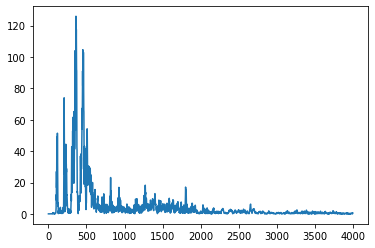

Writing sound.wav


In [9]:
import sys
sys.path.insert(0, 'ThinkDSP/code/') 
import thinkdsp
import matplotlib.pyplot as pyplot
import IPython

# Read in audio file
# FIXME - will this work for non wav files
wave = thinkdsp.read_wave('/content/recordings/0_jackson_0.wav')

# Plot spectrum of audio file
spectrum = wave.make_spectrum()
spectrum.plot()
pyplot.show()

# Play audio file
wave.play()
IPython.display.Audio('sound.wav')

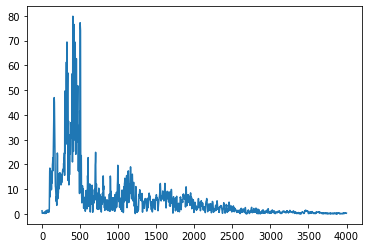

Writing sound.wav


In [10]:
# Read in audio file
# FIXME - will this work for non wav files
wave = thinkdsp.read_wave('/content/recordings/0_yweweler_0.wav')

# Plot spectrum of audio file
spectrum = wave.make_spectrum()
spectrum.plot()
pyplot.show()

# Play audio file
wave.play()
IPython.display.Audio('sound.wav')

## Creating dataframe

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0

In [6]:
df_audio = pd.DataFrame({'path' : all_files, 'label' : label})

In [7]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [13]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [8]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33) #don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [9]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
from sklearn.model_selection import train_test_split
X = df_audio['path']
y = df_audio['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45, stratify=y)

<font size=4>Grader function 3 </font>

In [16]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [10]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    # loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [18]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
raw_data = []
duration = []

for path in X_train:
    raw, dur = load_wav(path)
    raw_data.append(raw)
    duration.append(dur)

X_train_processed = pd.DataFrame({'raw_data' : raw_data, 'duration' : duration}, index=X_train.index)

In [19]:
raw_data = []
duration = []

for path in X_test:
    raw, dur = load_wav(path)
    raw_data.append(raw)
    duration.append(dur)

X_test_processed = pd.DataFrame({'raw_data' : raw_data, 'duration' : duration}, index=X_test.index)

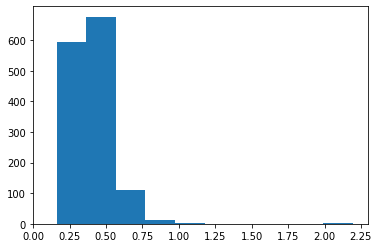

In [20]:
#plot the histogram of the duration for trian
plt.hist(X_train_processed['duration'])
plt.xticks(np.arange(0, 2.50, 0.25))
plt.yticks(np.arange(0, 700, 100))
plt.show()

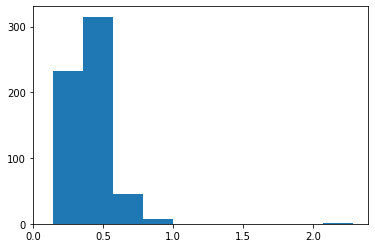

In [21]:
# plot the histogram of the duration for test
plt.hist(X_test_processed['duration'])
plt.xticks(np.arange(0, 2.50, 0.5))
plt.yticks(np.arange(0, 400, 100))
plt.show()

In [22]:
for i in range(0, 101, 10):
    print('{}th percentile is: {}'.format(i, np.percentile(X_train_processed['duration'], i)))

0th percentile is: 0.16104308390022676
10th percentile is: 0.2608934240362812
20th percentile is: 0.2980680272108844
30th percentile is: 0.3309115646258503
40th percentile is: 0.3582222222222222
50th percentile is: 0.38834467120181404
60th percentile is: 0.41551020408163264
70th percentile is: 0.44616780045351473
80th percentile is: 0.48431746031746037
90th percentile is: 0.5557097505668934
100th percentile is: 2.195918367346939


In [23]:
# print 90 to 100 percentile values with step size of 1. 
for i in range(90, 101):
    print('{}th percentile is: {}'.format(i, np.percentile(X_train_processed['duration'], i)))

90th percentile is: 0.5557097505668934
91th percentile is: 0.5698648526077099
92th percentile is: 0.5815492063492064
93th percentile is: 0.5975705215419505
94th percentile is: 0.6143537414965986
95th percentile is: 0.6269614512471655
96th percentile is: 0.6420807256235828
97th percentile is: 0.6586693877551021
98th percentile is: 0.6883972789115647
99th percentile is: 0.7907138321995464
100th percentile is: 2.195918367346939


<font size=4>Grader function 4 </font>

In [24]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [16]:
max_length  = 17640

In [26]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays, mask vector dtype must be bool.
X_train_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_processed['raw_data'],
    maxlen=max_length,
    dtype='float32',
    padding='post',
    truncating='post'
    )

In [27]:
X_test_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(
    X_test_processed['raw_data'],
    maxlen=max_length,
    dtype='float32',
    padding='post',
    truncating='post'
    )

In [28]:
X_train_mask = []
for ele in X_train_pad_seq:
    b = []
    for i in ele:
        if i != 0:
            b.append(bool(1))
        else:
            b.append(bool(0))
    X_train_mask.append((b))

# masks = np.array( [1]*token_length + [0]*(max_length-token_length))

In [29]:
X_test_mask = []

for ele in X_test_pad_seq:
    b = []
    for i in ele:
        if i != 0:
            b.append(bool(1))
        else:
            b.append(bool(0))
    X_test_mask.append((b))

In [30]:
X_train_mask = np.array(X_train_mask)
X_test_mask = np.array(X_test_mask)

<font size=4>Grader function 5 </font>

In [31]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). Also check the datatype of class labels(y_values) and make sure that you convert your class labels  to integer datatype before fitting in the model.
3. While defining your model make sure that you pass both the input layer and mask input layer as input to lstm layer as follows
<img src='https://i.imgur.com/FvcgvbY.jpg'>
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 

5. make sure that it won't overfit. 
6. You are free to include any regularization


In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, LSTM, Dense
from keras.models import Model
import datetime

In [ ]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [13]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
from sklearn.metrics import f1_score

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.x_test = validation_data[0]
        self.y_test = validation_data[1]
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict =  (np.asarray(self.model.predict(self.x_test)))
        val_label = np.argmax(val_predict, axis=1)
        val_targ = self.y_test
        val_f1 = f1_score(val_targ, val_label, average='micro')
        
        print(' - Val_F1_score: ', round(val_f1, 4))

In [36]:
f1_call = Metrics(validation_data=([X_test_pad_seq, X_test_mask], y_test))

In [39]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.1):
          print("\n Val_accuracy Reached 10% so cancelling training!")
          self.model.stop_training = True

In [40]:
stop_here = myCallback()

In [39]:
X_train_pad_seq[1].shape

(17640,)

In [44]:
input_layer = tf.keras.layers.Input(shape=(X_train_pad_seq.shape[1],1), dtype=float )
input_mask = tf.keras.layers.Input(shape=(X_train_mask.shape[1]), dtype=bool)

lstm = tf.keras.layers.LSTM(64)
#lstm_output = lstm(input_layer)

lstm_layer = lstm(inputs=input_layer, mask=input_mask)
dense_1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(seed=46))(lstm_layer)
dense_2 = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=keras.initializers.GlorotUniform(seed=46))(dense_1)

In [45]:
model_one = Model(inputs=[input_layer, input_mask], outputs=dense_2)
model_one.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model_one.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           16896       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 64)           4160        ['lstm_1[0][0]']           

In [46]:
#train your model
model_one.fit([X_train_pad_seq, X_train_mask], y_train,
          validation_data=([X_test_pad_seq, X_test_mask], y_test),
          epochs=3,
          verbose=1,
          batch_size=10,
          callbacks=[f1_call, stop_here, tensorboard_callback])

Epoch 1/3
140/140 [==============================] - ETA: 0s - loss: 2.3039 - accuracy: 0.0921 - Val_F1_score:  0.1

 Val_accuracy Reached 10% so cancelling training!
140/140 [==============================] - 224s 2s/step - loss: 2.3039 - accuracy: 0.0921 - val_loss: 2.3026 - val_accuracy: 0.1000


In [2]:
accuracy_m1, val_accuracy_m1 = 0.0921 , 0.1000

In [ ]:
# %tensorboard --logdir logs/fit

### 2. Converting into spectrogram and giving spectrogram data as input  

We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [15]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [48]:
## use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad_seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = []
for _ in range(len(X_train_pad_seq)):
    X_train_spectrogram.append(convert_to_spectrogram(X_train_pad_seq[_]))

X_test_spectrogram = []
for _ in range(len(X_test_pad_seq)):
    X_test_spectrogram.append(convert_to_spectrogram(X_test_pad_seq[_]))

In [49]:
X_train_spectrogram = np.array(X_train_spectrogram)
X_test_spectrogram = np.array(X_test_spectrogram)

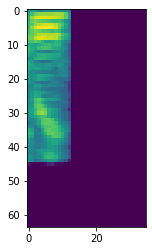

In [50]:
plt.imshow(X_test_spectrogram[0], interpolation='nearest')
plt.show()

<font size=4>Grader function 6 </font>

In [51]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400, 64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. <br>
(ex: Output from LSTM will be  (None, time_steps, features) average the output of every time step i.e, you should get (None,time_steps) 
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use custom micro F1 score as metric) and histograms of gradients. You can write your code for computing F1 score using this <a  href='https://i.imgur.com/8YULUcu.jpg'>link</a> 
5. make sure that it won't overfit. 
6. You are free to include any regularization


In [52]:
# write the architecture of the model
# print model.summary and make sure that it is following point 2 mentioned above
input_layer_m2 = tf.keras.layers.Input(shape=(64,35), dtype=float)

#lstm = tf.keras.layers.LSTM(32, return_sequences=True)
#lstm_output = lstm(input_layer)

lstm_layer_m2 = tf.keras.layers.LSTM(64, return_sequences=True)(input_layer_m2)
global_avg_pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(lstm_layer_m2)
dense_1_m2 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(seed=46))(global_avg_pooling_layer)
dense_2_m2 = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=keras.initializers.GlorotUniform(seed=46))(dense_1_m2)

In [53]:
f1_call = Metrics(validation_data=(X_test_spectrogram, y_test))

In [65]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.8):
          print("\n Val_accuracy Reached 80+ % so cancelling training!")
          self.model.stop_training = True

In [66]:
stop_here = myCallback()

In [60]:
#compile and fit your model.
model_two = Model(inputs=input_layer_m2, outputs=dense_2_m2)
model_two.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model_two.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 64, 64)            25600     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_______________________________________________________

In [67]:
#model2.fit([X_train_spectrogram],y_train_int,......)
model_two.fit([X_train_spectrogram], y_train,
          validation_data=([X_test_spectrogram], y_test),
          epochs=100,
          verbose=1,
          batch_size=8,
          callbacks=[f1_call, stop_here, tensorboard_callback])

175/175 [==============================] - 4s 21ms/step - loss: 0.4331 - accuracy: 0.8664 - val_loss: 0.7062 - val_accuracy: 0.7683
Epoch 2/100
175/175 [==============================] - 4s 23ms/step - loss: 0.4322 - accuracy: 0.8707 - val_loss: 0.7183 - val_accuracy: 0.7767
Epoch 3/100
175/175 [==============================] - 5s 26ms/step - loss: 0.4335 - accuracy: 0.8650 - val_loss: 0.7236 - val_accuracy: 0.7700
Epoch 4/100
175/175 [==============================] - 4s 25ms/step - loss: 0.4297 - accuracy: 0.8650 - val_loss: 0.7128 - val_accuracy: 0.7783
Epoch 5/100
175/175 [==============================] - 4s 21ms/step - loss: 0.4324 - accuracy: 0.8686 - val_loss: 0.7171 - val_accuracy: 0.7783
Epoch 6/100
175/175 [==============================] - 4s 21ms/step - loss: 0.4305 - accuracy: 0.8707 - val_loss: 0.7151 - val_accuracy: 0.7817
Epoch 7/100
175/175 [==============================] - 4s 21ms/step - loss: 0.4332 - accuracy: 0.8614 - val_loss: 0.7118 - val_accuracy: 0.7867
Epoc

In [3]:
accuracy_m2, val_accuracy_m2 = 0.8614, 0.7867

In [ ]:
# %tensorboard --logdir logs/fit

### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [17]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path, get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [18]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [19]:
len(aug_temp)

9

## Follow the steps 

1. Split data 'df_audio' into train and test (80-20 split)

2. We have 2000 data points(1600 train points, 400 test points) 



In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_audio['path'], df_audio['label'], random_state=45, test_size=0.2, stratify=df_audio['label'])

3. Do augmentation only on X_train,pass each point of X_train to generate_augmented_data function.After augmentation we will get 14400 train points. Make sure that you are augmenting the corresponding class labels (y_train) also.
4. Preprocess your X_test using load_wav function.
5. Convert the augmented_train_data and test_data to numpy arrays.
6. Perform padding and masking on augmented_train_data and test_data.
7. After padding define the model similar to model 1 and fit the data

<font color='red'> Note </font> - While fitting your model on the augmented data for model 3 you might face Resource exhaust error. One simple hack to avoid that is save the augmented_train_data,augment_y_train,test_data and y_test to Drive or into your local system. Then restart the runtime so that now you can train your model with full RAM capacity. Upload these files again in the new runtime session perform padding and masking and then fit your model.

In [21]:
# augmentation only X_train using generate_augmented_data()
augmented_X_train_data = []
for i in X_train:
    aug_temp = []
    aug_temp = generate_augmented_data(i)

    for j in aug_temp:
        augmented_X_train_data.append(j)

In [22]:
len(augmented_X_train_data)

14400

In [27]:
augmented_X_train_data = np.array(augmented_X_train_data)

In [23]:
# y_train after augmentation
augmented_y_train_data = []
for n in y_train:
    augmented_y_train_data.extend([n for i in range(9)]) # 14400/1600 = 9

In [24]:
len(augmented_y_train_data)

14400

In [25]:
augmented_y_train_data = np.array(augmented_y_train_data)

In [28]:
# Preprocess X_test
raw_data = []
duration = []

for path in X_test:
    raw, dur = load_wav(path)
    raw_data.append(raw)
    duration.append(dur)

X_test_processed = pd.DataFrame({'raw_data' : raw_data, 'duration' : duration}, index=X_test.index)

In [29]:
X_train_augmented_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(
    augmented_X_train_data,
    maxlen=max_length,
    dtype='float32',
    padding='post',
    truncating='post'
    )

In [30]:
X_test_augmented_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(
    X_test_processed['raw_data'],
    maxlen=max_length,
    dtype='float32',
    padding='post',
    truncating='post'
    )

In [31]:
X_train_augmented_mask = []
for ele in X_train_augmented_pad_seq:
    b = []
    for i in ele:
        if i != 0:
            b.append(bool(1))
        else:
            b.append(bool(0))
    X_train_augmented_mask.append((b))

# masks = np.array( [1]*token_length + [0]*(max_length-token_length))

In [32]:
X_test_augmented_mask = []

for ele in X_test_augmented_pad_seq:
    b = []
    for i in ele:
        if i != 0:
            b.append(bool(1))
        else:
            b.append(bool(0))
    X_test_augmented_mask.append((b))

In [33]:
X_train_augmented_mask = np.array(X_train_augmented_mask)
X_test_augmented_mask = np.array(X_test_augmented_mask)

In [34]:
input_layer_m3 = tf.keras.layers.Input(shape=(X_train_augmented_pad_seq.shape[1],1), dtype=float )
input_mask_m3 = tf.keras.layers.Input(shape=(X_train_augmented_mask.shape[1]), dtype=bool)

lstm = tf.keras.layers.LSTM(32)
#lstm_output = lstm(input_layer)

lstm_layer_m3 = lstm(inputs=input_layer_m3, mask=input_mask_m3)
dense_1_m3 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(seed=46))(lstm_layer_m3)
dense_2_m3 = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=keras.initializers.GlorotUniform(seed=46))(dense_1_m3)

In [35]:
model_three = Model(inputs=[input_layer_m3, input_mask_m3], outputs=dense_2_m3)
model_three.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model_three.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 32)           4352        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           2112        ['lstm[0][0]']               

In [36]:
f1_call = Metrics(validation_data=([X_test_augmented_pad_seq, X_test_augmented_mask], y_test))

In [42]:
#train your model
model_three.fit([X_train_augmented_pad_seq, X_train_augmented_mask], augmented_y_train_data,
          validation_data=([X_test_augmented_pad_seq, X_test_augmented_mask], y_test),
          epochs=3,
          verbose=1,
          batch_size=32,
          callbacks=[f1_call, stop_here, tensorboard_callback])

Epoch 1/3
450/450 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.0947 - Val_F1_score:  0.1

 Val_accuracy Reached 10% so cancelling training!
450/450 [==============================] - 618s 1s/step - loss: 2.3031 - accuracy: 0.0947 - val_loss: 2.3026 - val_accuracy: 0.1000


In [4]:
accuracy_m3, val_accuracy_m3 = 0.0947, 0.1000

In [ ]:
# %tensorboard --logdir logs/fit

### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [43]:
## use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad_seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_augmented_spectrogram = []
for _ in range(len(X_train_augmented_pad_seq)):
    X_train_augmented_spectrogram.append(convert_to_spectrogram(X_train_augmented_pad_seq[_]))

X_test_augmented_spectrogram = []
for _ in range(len(X_test_augmented_pad_seq)):
    X_test_augmented_spectrogram.append(convert_to_spectrogram(X_test_augmented_pad_seq[_]))

In [44]:
X_train_augmented_spectrogram = np.array(X_train_augmented_spectrogram)
X_test_augmented_spectrogram = np.array(X_test_augmented_spectrogram)

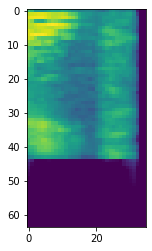

In [45]:
plt.imshow(X_train_augmented_spectrogram[0], interpolation='nearest')
plt.show()

In [46]:
f1_call = Metrics(validation_data=([X_test_augmented_spectrogram], y_test))

In [47]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.8):
          print("\n Val_accuracy Reached 80+ % so cancelling training!")
          self.model.stop_training = True

In [48]:
stop_here = myCallback()

In [49]:
# write the architecture of the model
# print model.summary and make sure that it is following point 2 mentioned above
input_layer_m4 = tf.keras.layers.Input(shape=(64,35), dtype=float)

#lstm = tf.keras.layers.LSTM(32, return_sequences=True)
#lstm_output = lstm(input_layer)

lstm_layer_m4 = tf.keras.layers.LSTM(64, return_sequences=True)(input_layer_m4)
global_avg_pooling_layer_m4 = tf.keras.layers.GlobalAveragePooling1D()(lstm_layer_m4)
dense_1_m4 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(seed=46))(global_avg_pooling_layer_m4)
dense_2_m4 = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=keras.initializers.GlorotUniform(seed=46))(dense_1_m4)

In [50]:
#compile and fit your model.
model_four = Model(inputs=input_layer_m4, outputs=dense_2_m4)
model_four.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model_four.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 64, 64)            25600     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_______________________________________________________

In [52]:
#model4.fit([X_train_augmented_spectrogram],y_train_int,......)
model_four.fit([X_train_augmented_spectrogram], augmented_y_train_data,
          validation_data=([X_test_augmented_spectrogram], y_test),
          epochs=25,
          verbose=1,
          batch_size=32,
          callbacks=[f1_call, stop_here, tensorboard_callback])

450/450 [==============================] - 12s 21ms/step - loss: 0.6332 - accuracy: 0.7779 - val_loss: 0.6804 - val_accuracy: 0.7575
Epoch 2/25
450/450 [==============================] - 8s 19ms/step - loss: 0.6278 - accuracy: 0.7794 - val_loss: 0.7184 - val_accuracy: 0.7275
Epoch 3/25
450/450 [==============================] - 8s 19ms/step - loss: 0.6198 - accuracy: 0.7829 - val_loss: 0.6981 - val_accuracy: 0.7500
Epoch 4/25
450/450 [==============================] - 8s 19ms/step - loss: 0.6280 - accuracy: 0.7798 - val_loss: 0.7521 - val_accuracy: 0.7425
Epoch 5/25
450/450 [==============================] - 8s 19ms/step - loss: 0.6527 - accuracy: 0.7674 - val_loss: 0.7615 - val_accuracy: 0.7400
Epoch 6/25
450/450 [==============================] - 8s 19ms/step - loss: 0.6309 - accuracy: 0.7785 - val_loss: 0.6919 - val_accuracy: 0.7450
Epoch 7/25
450/450 [==============================] - 9s 19ms/step - loss: 0.6082 - accuracy: 0.7873 - val_loss: 0.6698 - val_accuracy: 0.7800
Epoch 8/2

In [5]:
accuracy_m4, val_accuracy_m4 = 0.8004, 0.8125

In [ ]:
# %tensorboard --logdir logs/fit

<pre>
<h2>Observations:</h2>
- With Model 1, data size was quite small, but with Model 2, after converting raw data into spectrograms and using spectrograms as input, performance significantly increased. Raw audio data does not have the same value as spectrogram data.
-  We used the augmentation technique to get rid of the small data size problem with Models 3 and 4. But only with the new augmented data, Model 3's performance was not significantly better than Model 1, but with the spectrogram of this new data, Model 4's performance was quite satisfactory. Our validation accuracy was 81% within 14 epochs.
</pre>

In [6]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Data", "Train Accuracy", "Val_Accuracy/F1 Score"]

x.add_row(["Model-1", "Raw Data", round(accuracy_m1,2),round(val_accuracy_m1,2)])
x.add_row(["Model-2", "Spectrigramed Data", round(accuracy_m2,2),round(val_accuracy_m2,2)])
x.add_row(["Model-3", "Augmented Data", round(accuracy_m3,2),round(val_accuracy_m3,2)])
x.add_row(["Model-4", "Augmented + Spectrogram Data", round(accuracy_m4,2),round(val_accuracy_m4,2)])

print(x)

+---------+------------------------------+----------------+-----------------------+
|  Model  |             Data             | Train Accuracy | Val_Accuracy/F1 Score |
+---------+------------------------------+----------------+-----------------------+
| Model-1 |           Raw Data           |      0.09      |          0.1          |
| Model-2 |      Spectrigramed Data      |      0.86      |          0.79         |
| Model-3 |        Augmented Data        |      0.09      |          0.1          |
| Model-4 | Augmented + Spectrogram Data |      0.8       |          0.81         |
+---------+------------------------------+----------------+-----------------------+
